In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data as ld
from pytorchtools import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
from metrics import mae
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch

In [2]:
window_size = 50
task_size = None
stride = 1
#window_size = 20
batch_size = 1024
output_dim = 1
input_dim = 14
learning_rate = 0.0001
max_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

### Window size for pollution dataset

In [3]:

train_dataset, validation_dataset, test_dataset = ld.load_data_pollution(window_size, task_size, stride=1, mode="no-meta-learning")

train_dataset.x = train_dataset.x.reshape(-1, train_dataset.dim*window_size)
validation_dataset.x = validation_dataset.x.reshape(-1, validation_dataset.dim*window_size)

train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(validation_dataset, **params)

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)


KeyboardInterrupt: 

In [4]:
model_file = "../Models/linear_model.pt"
patience = 10
early_stopping = EarlyStopping(patience=patience, model_file=model_file, verbose=False)

In [5]:
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, seq_len):
        
        super(LinearModel, self).__init__()
        self.n_features = input_dim*seq_len
        self.linear = nn.Linear(self.n_features, output_dim)
        
    def forward(self, x):
        
        out = self.linear(x.view(-1,self.n_features))
        return out
    
def get_regularization_term(model, norm_type):
    
    all_params= []
    for name, param in model.named_parameters():
        if(name.split(".")[1]=="bias"):
            all_params.append(param)
    all_params = torch.cat(all_params)
    
    term = torch.norm(all_params, 1) if norm_type=="l1" else torch.norm(all_params, 2)
    return term
    
def train_iteration(model, train_loader, device, loss=mae):
    
    lambda1 = 0.1
    train_loss = 0.0
    for x_train, y_train in train_loader:
    
        model.zero_grad()
        x_train, y_train = torch.tensor(x_train).to(device).float(), torch.tensor(y_train).float().to(device)

        y_pred = model(x_train)
        loss_ = loss(y_pred, y_train) + lambda1+get_regularization_term(model, "l1" )
        loss_.backward()
        optimizer.step()
        train_loss += loss_.cpu().data.numpy()*x_train.shape[0] 
        
    train_loss = train_loss/len(train_loader.dataset)
    print("Train loss:", train_loss)
    
    return train_loss


def eval_iteration(model, eval_loader, device, loss=mae):
    
    #for validation and testing
    
    eval_loss = 0.0
    for x_eval, y_eval in eval_loader:
        x_eval, y_eval = torch.tensor(x_eval).float().to(device), torch.tensor(y_eval).float().to(device)
        model.batch_size = x_eval.shape[0]
        y_pred = model(x_eval)
        eval_loss += loss(y_pred, y_eval).cpu().data.numpy()*x_eval.shape[0]
    eval_loss /= (len(eval_loader.dataset))
    return eval_loss

In [68]:
get_regularization_term(model, "l1")

tensor(5.7824e-06, device='cuda:0', grad_fn=<NormBackward0>)

In [69]:
model = LinearModel(input_dim, output_dim, window_size )
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)




In [7]:
window_size_options = 2**(np.arange(0,9))
#window_size_options = [2**7]
windows_loss = []

for window_size in window_size_options:


    train_dataset, validation_dataset, test_dataset = ld.load_data_pollution(window_size, task_size, stride=1, mode="no-meta-learning")

    train_dataset.x = train_dataset.x.reshape(-1, train_dataset.dim*window_size)
    validation_dataset.x = validation_dataset.x.reshape(-1, validation_dataset.dim*window_size)

    train_loader = DataLoader(train_dataset, **params)
    val_loader = DataLoader(validation_dataset, **params)
    
    model = LinearModel(input_dim, output_dim, window_size )
    model.to(device)

    #learning_rate_ = learning_rate/window_size
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
    early_stopping = EarlyStopping(patience=patience, model_file=model_file, verbose=False)
    
    val_loss_list = []

    for i in range(max_epochs):

        train_loss = train_iteration(model, train_loader, device)
        val_loss = eval_iteration(model, val_loader, device)

        print(val_loss)
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
                print("Early stopping")
                break

        # load the last checkpoint with the best model
        model.load_state_dict(torch.load(model_file))
        
    model.load_state_dict(torch.load(model_file))  
    val_loss =  eval_iteration(model, val_loader, device)
    print("Final val loss:", val_loss)
    windows_loss.append(val_loss)

x shape: (52583, 1, 14)
y shape: (52583, 1)
x shape: (52583, 1, 14)
y shape: (52583, 1)
x shape: (52583, 1, 14)
y shape: (52583, 1)
x shape: (52583, 1, 14)
y shape: (52583, 1)
x shape: (52583, 1, 14)
y shape: (52583, 1)


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss: 0.3984290574735612


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.28266634328856416
Train loss: 0.3565733464327376
0.24942888717986395
Train loss: 0.31744697142494016
0.21817564989260532
Train loss: 0.2843234621721435
0.18762326205144936
Train loss: 0.2619670714337899
0.1576917644360528
Train loss: 0.2416522662934405
0.12916178328196035
Train loss: 0.22334694826904986
0.10279464452578596
Train loss: 0.20731713351662281
0.07962450238286801
Train loss: 0.19371353461844887
0.06148723227959888
Train loss: 0.18282983910837264
0.0521294628010763
Train loss: 0.17485194310723226
0.04797468027276905
Train loss: 0.16956994146856194
0.042906405006162364
Train loss: 0.16599464880204534
0.03867546210102218
Train loss: 0.1633534040380559
0.03583817728018374
Train loss: 0.16152071091730338
0.03451018381869571
Train loss: 0.16009689133145608
0.03414907485226538
Train loss: 0.1589840050922498
0.034478848828791146
EarlyStopping counter: 1 out of 10
Train loss: 0.1589817728687555
0.03452024551840778
EarlyStopping counter: 2 out of 10
Train loss: 0.15895805901201743
0

Train loss: 0.16015617260102882
0.03821673945989176
EarlyStopping counter: 1 out of 10
Train loss: 0.16012529691737573
0.03873285285253316
EarlyStopping counter: 2 out of 10
Train loss: 0.16014198406239893
0.03740854030083899
Train loss: 0.15993692450033384
0.03710305951286291
Train loss: 0.15975049586706264
0.036924376344615484
Train loss: 0.15959517272908394
0.03890395668526285
EarlyStopping counter: 1 out of 10
Train loss: 0.1595672031951062
0.03742013822467822
EarlyStopping counter: 2 out of 10
Train loss: 0.1595988204118131
0.03876663535624761
EarlyStopping counter: 3 out of 10
Train loss: 0.1595894724801772
0.03695401983314074
EarlyStopping counter: 4 out of 10
Train loss: 0.15960304545785428
0.038022368656594946
EarlyStopping counter: 5 out of 10
Train loss: 0.15958178972685208
0.03765670669265658
EarlyStopping counter: 6 out of 10
Train loss: 0.1595750680727271
0.037383956028623544
EarlyStopping counter: 7 out of 10
Train loss: 0.15957347444961703
0.037420206810378914
EarlyStop

0.03887352628770986
EarlyStopping counter: 5 out of 10
Train loss: 0.16097280041506884
0.03907388043557971
EarlyStopping counter: 6 out of 10
Train loss: 0.16052089661821312
0.037560413522477014
EarlyStopping counter: 7 out of 10
Train loss: 0.16051782572381415
0.037487837235299304
EarlyStopping counter: 8 out of 10
Train loss: 0.16051858314162856
0.03780228759404002
EarlyStopping counter: 9 out of 10
Train loss: 0.1605117500123411
0.037864764169233046
EarlyStopping counter: 10 out of 10
Early stopping
Final val loss: 0.03593459555486278
x shape: (52456, 128, 14)
y shape: (52456, 1)
x shape: (52456, 128, 14)
y shape: (52456, 1)
x shape: (52456, 128, 14)
y shape: (52456, 1)
x shape: (52456, 128, 14)
y shape: (52456, 1)
x shape: (52456, 128, 14)
y shape: (52456, 1)
Train loss: 0.2705229104313645
0.09816783405834716
Train loss: 0.19500726227791584
0.07109769721442613
Train loss: 0.1796647073100406
0.05785819487292555
Train loss: 0.17352830371024752
0.05790923647122338
EarlyStopping counte

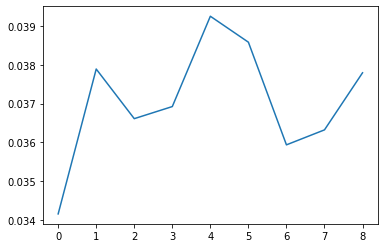

In [8]:
plt.plot(windows_loss)

In [11]:
pd.DataFrame({"Window size":2**np.arange(9), "Val loss":windows_loss})

,Window size,Val loss
0,1,0.034149
1,2,0.037894
2,4,0.036612
3,8,0.036924
4,16,0.039259
5,32,0.038588
6,64,0.035935
7,128,0.036322
8,256,0.037797


According to this, and the literature (Air Quality Prediction in Smart Cities Using Machine Learning Technologies Based on Sensor Data: A Review) the best window size is 5.

### Window size for batteries

In [12]:
task_size = None
stride = 1
batch_size = 1024
output_dim = 1
input_dim = 3
learning_rate = 0.0001
max_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

model = LinearModel(input_dim, output_dim, window_size )
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)


In [14]:
window_size_options = 2**(np.arange(0,9))
windows_loss = []

for window_size in window_size_options:


    train_dataset, validation_dataset, test_dataset = ld.load_battery_data(window_size, task_size, stride=5, mode="no-meta-learning")

    train_dataset.x = train_dataset.x.reshape(-1, train_dataset.dim*window_size)
    validation_dataset.x = validation_dataset.x.reshape(-1, validation_dataset.dim*window_size)

    train_loader = DataLoader(train_dataset, **params)
    val_loader = DataLoader(validation_dataset, **params)
    
    model = LinearModel(input_dim, output_dim, window_size )
    model.to(device)

    #learning_rate_ = learning_rate/window_size
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
    early_stopping = EarlyStopping(patience=patience, model_file=model_file, verbose=False)
    
    val_loss_list = []

    for i in range(max_epochs):

        train_loss = train_iteration(model, train_loader, device)
        val_loss = eval_iteration(model, val_loader, device)

        print(val_loss)
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
                print("Early stopping")
                break

        # load the last checkpoint with the best model
        model.load_state_dict(torch.load(model_file))
        
    model.load_state_dict(torch.load(model_file))  
    val_loss =  eval_iteration(model, val_loader, device)
    print("Final val loss:", val_loss)
    windows_loss.append(val_loss)

x shape: (13786, 1, 3)
y shape: (13786, 1)
x shape: (56852, 1, 3)
y shape: (56852, 1)
x shape: (19414, 1, 3)
y shape: (19414, 1)
x shape: (13786, 1, 3)
y shape: (13786, 1)
x shape: (19414, 1, 3)
y shape: (19414, 1)
x shape: (19414, 1, 3)
y shape: (19414, 1)
x shape: (56852, 1, 3)
y shape: (56852, 1)
x shape: (19414, 1, 3)
y shape: (19414, 1)
x shape: (12932, 1, 3)
y shape: (12932, 1)
x shape: (18925, 1, 3)
y shape: (18925, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (18905, 1, 3)
y shape: (18905, 1)
x shape: (56852, 1, 3)
y shape: (56852, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (12817, 1, 3)
y shape: (12817, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (12751, 1, 3)
y shape: (12751, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (19414, 1, 3)
y shape: (19414, 1)
x shape: (12508, 1, 3)
y shape: (12508, 1)
x shape: (18830, 1, 3)
y shape: (18830, 1)
x shape: (56782, 1, 3)
y shape: (56782, 1)
x shape: (1

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss: 0.7259630053562437


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.6157758177398442
Train loss: 0.6128509664287479
0.5903140468950261
Train loss: 0.6096729906037671
0.5826608193960837
Train loss: 0.6093026417691523
0.578561683389656
Train loss: 0.6092322419845168
0.57614507283497
Train loss: 0.6092168715888797
0.5736108596046507
Train loss: 0.6092122039412057
0.5730230621393703
Train loss: 0.6092104124596032
0.5731293619602713
EarlyStopping counter: 1 out of 10
Train loss: 0.6092108093614408
0.5732801580144706
EarlyStopping counter: 2 out of 10
Train loss: 0.6092108550299505
0.5707542721118195
Train loss: 0.6092093958354158
0.5706219410504147
Train loss: 0.6092086657587754
0.5709738635344933
EarlyStopping counter: 1 out of 10
Train loss: 0.6092093605214415
0.5714985574281052
EarlyStopping counter: 2 out of 10
Train loss: 0.6092081798019592
0.5702562869508747
Train loss: 0.6092086926485633
0.5695018599902781
Train loss: 0.6092075645390538
0.5697561420516852
EarlyStopping counter: 1 out of 10
Train loss: 0.609207530022617
0.5696926952877103
EarlyStopp

Train loss: 0.6097656110768915
0.48980922597434073
EarlyStopping counter: 10 out of 10
Early stopping
Final val loss: 0.48604870270287137
x shape: (13785, 4, 3)
y shape: (13785, 1)
x shape: (56851, 4, 3)
y shape: (56851, 1)
x shape: (19413, 4, 3)
y shape: (19413, 1)
x shape: (13785, 4, 3)
y shape: (13785, 1)
x shape: (19413, 4, 3)
y shape: (19413, 1)
x shape: (19413, 4, 3)
y shape: (19413, 1)
x shape: (56851, 4, 3)
y shape: (56851, 1)
x shape: (19413, 4, 3)
y shape: (19413, 1)
x shape: (12931, 4, 3)
y shape: (12931, 1)
x shape: (18924, 4, 3)
y shape: (18924, 1)
x shape: (56781, 4, 3)
y shape: (56781, 1)
x shape: (18904, 4, 3)
y shape: (18904, 1)
x shape: (56851, 4, 3)
y shape: (56851, 1)
x shape: (56781, 4, 3)
y shape: (56781, 1)
x shape: (56781, 4, 3)
y shape: (56781, 1)
x shape: (12816, 4, 3)
y shape: (12816, 1)
x shape: (56781, 4, 3)
y shape: (56781, 1)
x shape: (12750, 4, 3)
y shape: (12750, 1)
x shape: (56781, 4, 3)
y shape: (56781, 1)
x shape: (19413, 4, 3)
y shape: (19413, 1)
x 

0.49982826166370103
EarlyStopping counter: 9 out of 10
Train loss: 0.6091677077625371
0.4997911878930242
EarlyStopping counter: 10 out of 10
Early stopping
Final val loss: 0.49966968134851486
x shape: (13784, 8, 3)
y shape: (13784, 1)
x shape: (56850, 8, 3)
y shape: (56850, 1)
x shape: (19412, 8, 3)
y shape: (19412, 1)
x shape: (13784, 8, 3)
y shape: (13784, 1)
x shape: (19412, 8, 3)
y shape: (19412, 1)
x shape: (19412, 8, 3)
y shape: (19412, 1)
x shape: (56850, 8, 3)
y shape: (56850, 1)
x shape: (19412, 8, 3)
y shape: (19412, 1)
x shape: (12930, 8, 3)
y shape: (12930, 1)
x shape: (18923, 8, 3)
y shape: (18923, 1)
x shape: (56780, 8, 3)
y shape: (56780, 1)
x shape: (18903, 8, 3)
y shape: (18903, 1)
x shape: (56850, 8, 3)
y shape: (56850, 1)
x shape: (56780, 8, 3)
y shape: (56780, 1)
x shape: (56780, 8, 3)
y shape: (56780, 1)
x shape: (12816, 8, 3)
y shape: (12816, 1)
x shape: (56780, 8, 3)
y shape: (56780, 1)
x shape: (12749, 8, 3)
y shape: (12749, 1)
x shape: (56780, 8, 3)
y shape: (5

KeyboardInterrupt: 

In [119]:
windows_loss

[0.5654301063821697,
 0.5459571618151449,
 0.3902780141327191,
 0.5119334775313236,
 0.47683301211923285,
 0.4741507570338974,
 0.39003581219008676,
 0.5020166005675418]

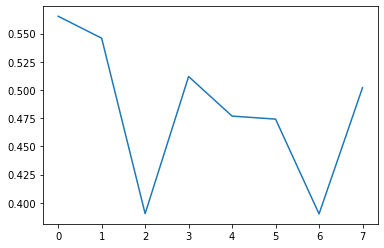

In [120]:
plt.plot(windows_loss)